In [8]:
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# from collections import Counter
import pandas as pd
import seaborn as sns
from matplotlib.font_manager import FontProperties
from itertools import combinations
from collections import defaultdict, Counter  # 添加了Counter和defaultdict的导入
import pandas as pd  # 添加pandas导入

# 中文显示配置（如果需要）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 替换为系统中有的中文字体
plt.rcParams['axes.unicode_minus'] = False

def load_and_analyze(json_path):
    """加载数据并进行分析"""
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    df_recipes = pd.DataFrame(data["recipes"])
    df_books = pd.DataFrame(data["books"])
    
    print(f"\n{'='*50}")
    print(f"数据集概览")
    print(f"书籍数量: {len(df_books)}")
    print(f"菜谱数量: {len(df_recipes)}")
    print(f"最早出版年份: {df_books['date'].min()}" if 'date' in df_books.columns else "")
    print(f"民族分类数量: {df_recipes['ethnic_group'].nunique()}")
    print(f"菜系类别数量: {df_recipes['class1'].nunique()}")
    print(f"最常用食材: {Counter([i for lst in df_recipes['ingredients'] for i in lst]).most_common(5)}")
    
    return df_recipes, df_books

def plot_ethnic_distribution(df):
    """民族分布可视化"""
    plt.figure(figsize=(14, 6))
    ethnic_counts = df['ethnic_group'].value_counts().head(20)
    
    ax = sns.barplot(
        x=ethnic_counts.index, 
        y=ethnic_counts.values,
        palette="viridis"
    )
    
    plt.title("各民族菜谱数量分布 (Top 20)", fontsize=14)
    plt.xlabel("民族", fontsize=12)
    plt.ylabel("菜谱数量", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    
    # 添加数值标签
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.0f}", 
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha="center", va="center", 
            xytext=(0, 5), 
            textcoords="offset points"
        )
    
    plt.tight_layout()
    plt.show()

def plot_class_distribution(df):
    """菜系类别分布可视化"""
    plt.figure(figsize=(12, 8))
    class_counts = df['class1'].value_counts()
    
    ax = sns.barplot(
        y=class_counts.index,
        x=class_counts.values,
        palette="rocket",
        orient="h"
    )
    
    plt.title("各类别菜谱数量分布", fontsize=14)
    plt.xlabel("菜谱数量", fontsize=12)
    plt.ylabel("类别", fontsize=12)
    
    # 添加数值标签
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(
            f"{width:.0f}",
            (width, p.get_y() + p.get_height() / 2.),
            ha="left", va="center",
            xytext=(5, 0),
            textcoords="offset points"
        )
    
    plt.tight_layout()
    plt.show()

def generate_ethnic_wordclouds(df, top_n=5):
    """生成各民族词云"""
    top_ethnic = df['ethnic_group'].value_counts().head(top_n).index
    
    for ethnic in top_ethnic:
        if ethnic == "": continue
        
        ethnic_recipes = df[df['ethnic_group'] == ethnic]
        all_ingredients = [
            ing 
            for lst in ethnic_recipes['ingredients'] 
            for ing in lst
        ]
        
        if not all_ingredients: continue
        
        # 生成词云
        wc = WordCloud(
            width=800, height=400,
            background_color="white",
            colormap="tab20",
            max_words=50,
            font_path=None  # 可指定中文字体路径如"SimHei.ttf"
        ).generate_from_frequencies(Counter(all_ingredients))
        
        # 绘制
        plt.figure(figsize=(12, 6))
        plt.imshow(wc, interpolation="bilinear")
        plt.title(f"{ethnic}民族常用食材词云 (共{len(ethnic_recipes)}道菜)", fontsize=14)
        plt.axis("off")
        plt.show()
        
        # 打印高频食材
        print(f"\n{ethnic}民族高频食材TOP10:")
        for item, count in Counter(all_ingredients).most_common(10):
            print(f"{item}: {count}次")

def plot_ingredient_network(df, min_count=10):
    """食材共现网络图（简化版）"""
    from itertools import combinations
    
    # 统计食材共现
    co_occurrence = defaultdict(int)
    for ingredients in df['ingredients']:
        for a, b in combinations(sorted(set(ingredients)), 2):
            co_occurrence[(a, b)] += 1
    
    # 转换为DataFrame
    edges = pd.DataFrame([
        {"source": a, "target": b, "weight": count}
        for (a, b), count in co_occurrence.items()
        if count >= min_count
    ])
    
    if edges.empty:
        print(f"没有找到出现次数超过{min_count}次的食材组合")
        return
    
    # 简单可视化
    plt.figure(figsize=(12, 12))
    for _, row in edges.iterrows():
        plt.plot(
            [0, 1], [0, 1],  # 简化示意，实际应使用networkx
            linewidth=row['weight']/min_count*0.5,
            alpha=0.3,
            color='blue'
        )
    
    plt.title(f"食材共现网络 (出现次数≥{min_count})", fontsize=14)
    plt.axis("off")
    plt.show()
    
    # 打印强关联食材对
    print("\n最强关联食材TOP10:")
    print(
        edges.sort_values("weight", ascending=False)
        .head(10)
        .reset_index(drop=True)
    )

# # 主执行流程
# if __name__ == "__main__":
#     # 加载数据
#     df_recipes, df_books = load_and_analyze("cookbooks_collection.json")
    
#     # 可视化1：民族分布
#     plot_ethnic_distribution(df_recipes)
    
#     # 可视化2：类别分布
#     plot_class_distribution(df_recipes)
    
#     # 可视化3：各民族词云
#     generate_ethnic_wordclouds(df_recipes, top_n=5)
    
#     # 可视化4：食材网络（需要networkx库）
#     try:
#         import networkx as nx
#         plot_ingredient_network(df_recipes)
#     except ImportError:
#         print("\n提示：安装networkx可获得更好的网络可视化效果")
#         print("运行: pip install networkx")

In [9]:
df_recipes, df_books = load_and_analyze("cookbooks_collection.json")


数据集概览
书籍数量: 76
菜谱数量: 5741

民族分类数量: 35
菜系类别数量: 8
最常用食材: [('butter', 2652), ('salt', 2534), ('water', 1551), ('sugar', 1539), ('sauce', 1273)]


C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_40096\2503878226.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


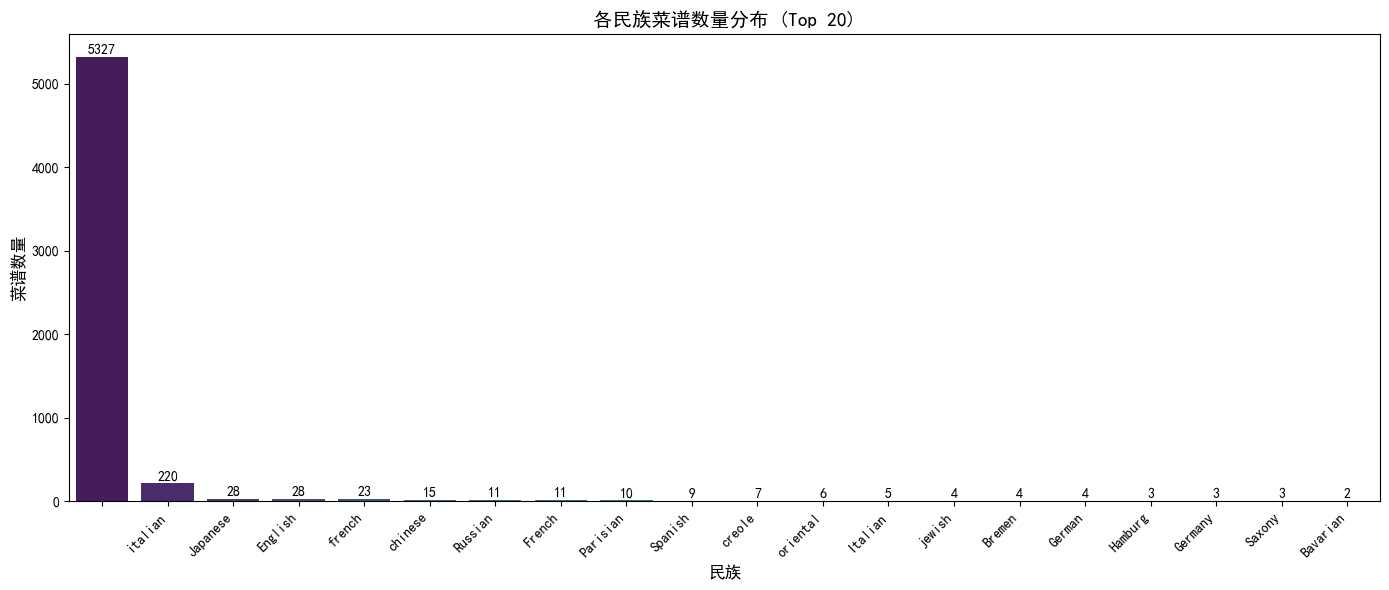

In [10]:
# 可视化1：民族分布
plot_ethnic_distribution(df_recipes)

C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_40096\2503878226.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


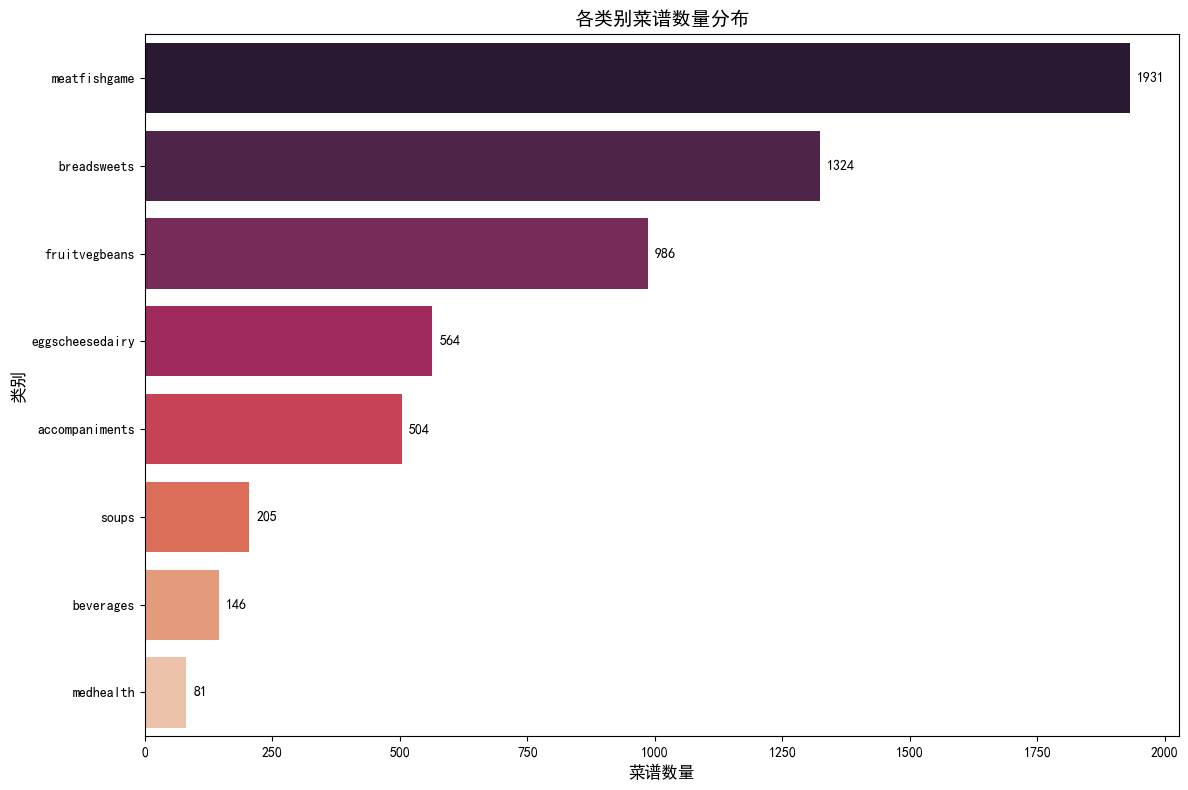

In [11]:
# 可视化2：类别分布
plot_class_distribution(df_recipes)

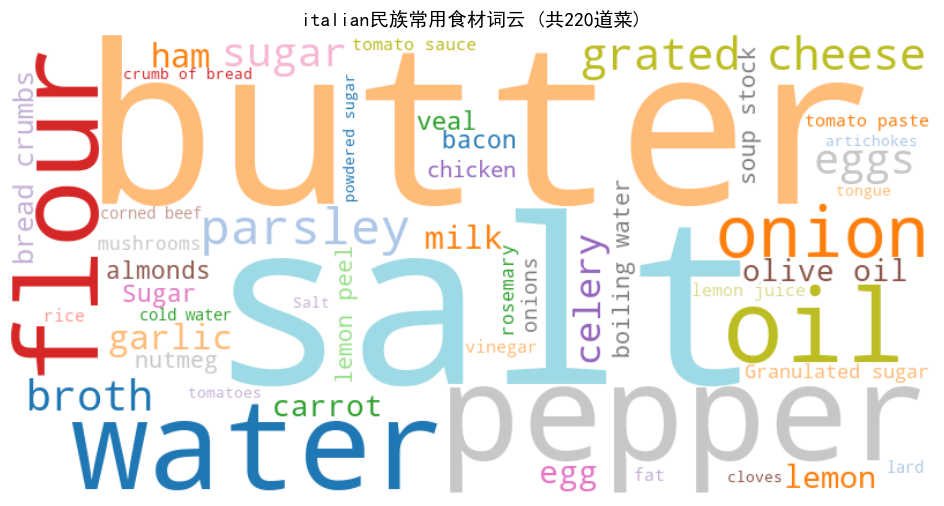


italian民族高频食材TOP10:
salt: 138次
butter: 127次
pepper: 104次
water: 87次
flour: 71次
oil: 56次
onion: 54次
parsley: 49次
grated cheese: 48次
eggs: 44次


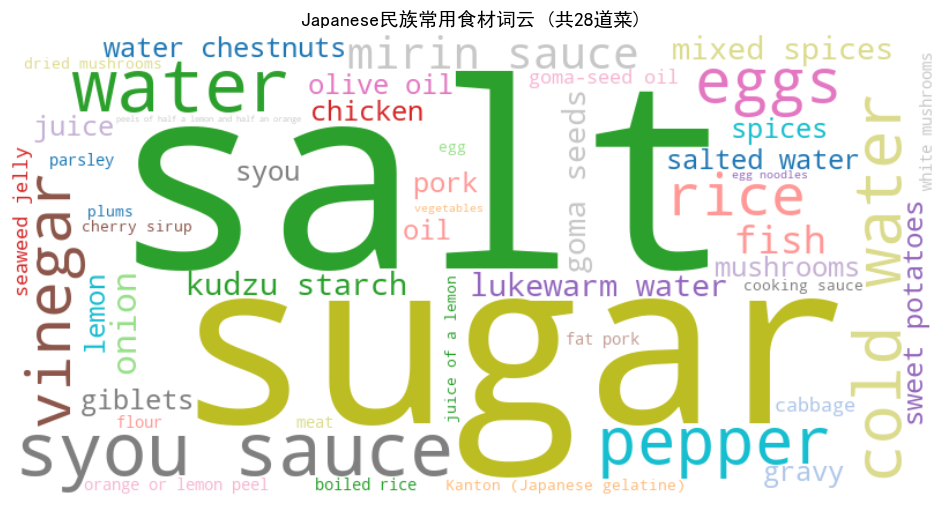


Japanese民族高频食材TOP10:
salt: 20次
sugar: 15次
syou sauce: 12次
water: 12次
cold water: 9次
pepper: 9次
eggs: 8次
vinegar: 8次
rice: 7次
mirin sauce: 7次


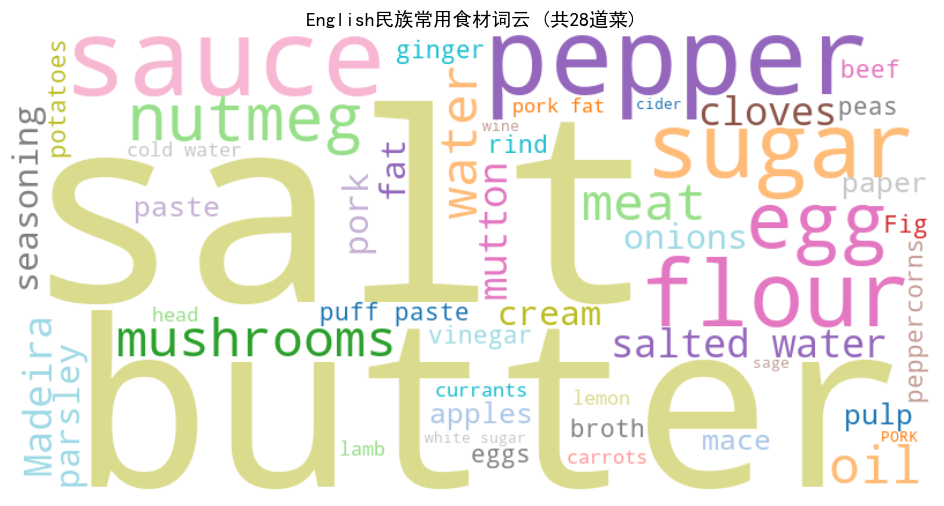


English民族高频食材TOP10:
salt: 17次
butter: 13次
pepper: 10次
sauce: 10次
sugar: 7次
flour: 7次
egg: 5次
nutmeg: 4次
mushrooms: 4次
oil: 4次


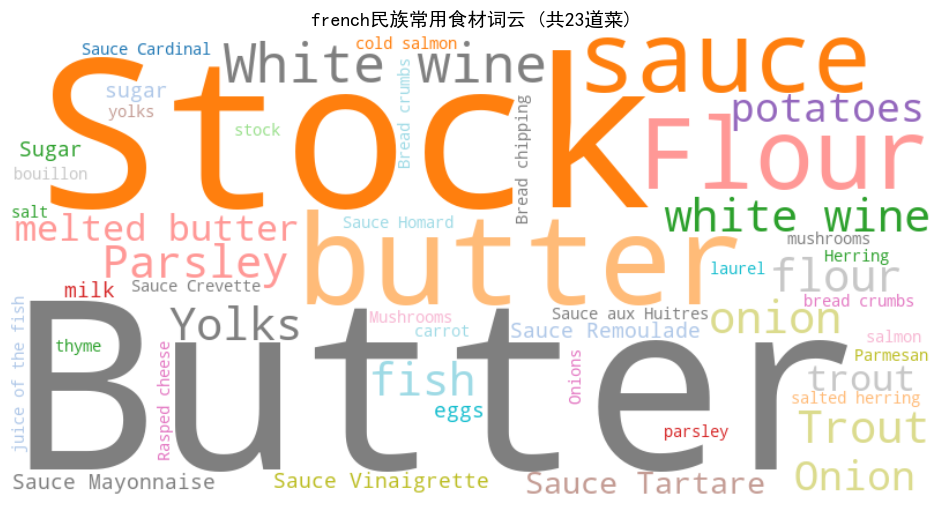


french民族高频食材TOP10:
Butter: 4次
Stock: 3次
butter: 3次
Flour: 3次
sauce: 3次
White wine: 3次
flour: 2次
Parsley: 2次
onion: 2次
white wine: 2次


In [12]:
# 可视化3：各民族词云
generate_ethnic_wordclouds(df_recipes, top_n=5)

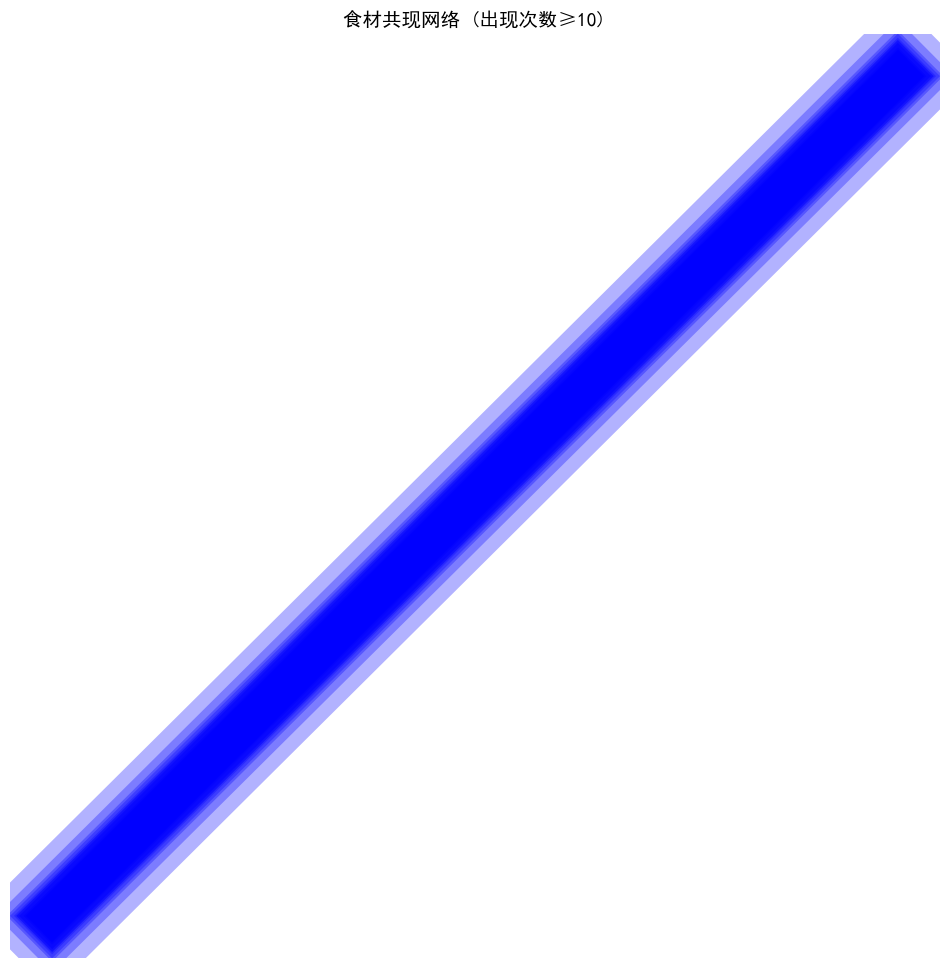


最强关联食材TOP10:
   source  target  weight
0  butter    salt    1541
1  pepper    salt    1144
2  butter   flour     928
3  butter  pepper     860
4    salt   water     780
5  butter   sauce     734
6   flour    salt     732
7  butter   water     680
8  butter    eggs     667
9    salt   sauce     582


In [13]:
# 可视化4：食材网络（需要networkx库）
try:
    import networkx as nx
    plot_ingredient_network(df_recipes)
except ImportError:
    print("\n提示：安装networkx可获得更好的网络可视化效果")
    print("运行: pip install networkx")